In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Correcting for Distortion

In [ ]:
# Read images to calibrate the camera
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)

In [2]:
import glob

#List of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all images
obj_points = [] #3D points in real world
img_points = [] #2D points in image plane

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for image in images:
    img = mpimg.imread(image)
    # Convert image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        img_points.append(corners)
        obj_points.append(objp)   

In [3]:
# Function to undistort an image
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

### Functions to calculate gradient threshold, magnitude of gradient and direction of gradient

In [4]:
def abs_thresh(img, orient='x', sobel_kernel=3, thresh=(25,255)):
    if orient=='x':
        sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel))
        scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
    elif orient=='y':
        sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel))
        scaled_sobel = np.uint8(255*sobely/np.max(sobely))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(25,100)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    binary_mag = np.zeros_like(scaled_sobel)
    binary_mag[(scaled_sobel >= thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_mag

def dir_threshold(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1,0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0,1, ksize=sobel_kernel))
    dir_sobel = np.arctan2(sobely, sobelx)
    binary_dir = np.zeros_like(dir_sobel)
    binary_dir[(dir_sobel >= thresh[0]) & (dir_sobel < thresh[1])] = 1
    return binary_dir

In [ ]:
# Combining different thresholds on gray image 
ksize = 15
gray = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2GRAY)
grady = abs_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(15, 150))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, thresh=(50, 255))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 4.9))

combined_gray = np.zeros_like(dir_binary)
combined_gray[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) ] = 1

# Combining different thresholds on s_channel image
ksize = 15
gray = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2HLS)
s_channel = hls[:,:,2]
gradx_s = abs_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady_s = abs_thresh(s_channel, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary_s = mag_thresh(s_channel, sobel_kernel=ksize, thresh=(50, 255))
dir_binary_s = dir_threshold(s_channel, sobel_kernel=ksize, thresh=(0.7, 4.9))

combined_s = np.zeros_like(dir_binary)
combined_s[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) ] = 1

### Combining gray and S-channel thresholds for an image

In [5]:
def combined_gray_sChannel(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary


In [6]:
# Function to apply perspective transform to the binary image

def perspective_transform(img):
    # Apply perspective transform to the binary image
    # Source and destination points for perspective transformation
    img_shape=(img.shape[1],img.shape[0])
    src = np.float32([[0,img_shape[1]],[img_shape[0]/2-120,img_shape[1]/2+100],[img_shape[0]/2+120,img_shape[1]/2+100],[img_shape[0],img_shape[1]]])
    dst = np.float32([[0,img_shape[1]],[0,0],[img_shape[0],0],[img_shape[0],img_shape[1]]])
    
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_shape)
    return warped, Minv

### Finding Lane Lines:
The warped image is used to identify lane lines.  

In [7]:
def finding_lines(warped):
    # Finding lane lines from the warped image
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[np.int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

### Calculating radius of curvature of the lane and its position with respect to the centre.

In [14]:
def find_curvature():
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
#     # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')

    return left_curverad, right_curverad


In [9]:
def vehicle_position(left_fit, right_fit):
    x_left = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    x_right = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    vehicle_centre = abs(640-((x_left+x_right)/2))
    return vehicle_centre

### Function to draw lane lines on the image

In [10]:
def draw_lines(img, Minv, left_fitx, right_fitx, ploty, img_undistorted):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undistorted, 1, newwarp, 0.3, 0)
    
    return result


### Pipeline to process an image

In [35]:
def process_image(img):
    img_undistorted = cal_undistort(img, obj_points, img_points)
    color_binary, combined_binary = combined_gray_sChannel(img_undistorted)
    warped, Minv = perspective_transform(combined_binary)

    left_fit, right_fit = finding_lines(warped)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    result = draw_lines(warped, Minv, left_fitx, right_fitx, ploty, img_undistorted)

    left_curvature, right_curvature = find_curvature()
    vehicle_centre = vehicle_position(left_fit, right_fit)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Curvature:{:.2f} m".format(int(left_curvature))
    cv2.putText(result, text,(50,75),font,1.5,(0,0,0),2)
    if vehicle_centre < 640:
        text = "Vehicle is {:.2f} m left of center".format(vehicle_centre*3.7/700)
    elif vehicle_centre > 640:
        text = "Vehicle is {:.2f} m right of center".format(vehicle_centre*3.7/700)
    cv2.putText(result, text, (50,150),font,1.5,(0,0,0),2)
    
    return result
#     plt.imshow(result)


In [33]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0

### Read a test image and pass it throught the pipeline

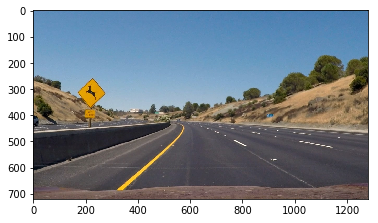

In [16]:
# Read lane images and undistort them
img = mpimg.imread('./test_images/test2.jpg')
plt.imshow(img)

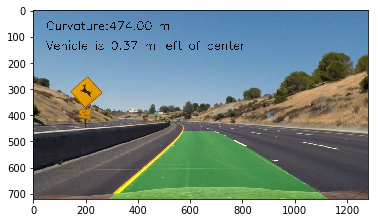

In [36]:
# Final output of the test image
plt.imshow(process_image(img))
plt.savefig('example_output')

### Test the pipeline on video file

In [38]:
left_line = Line()
right_line = Line()

yellow_output = '../project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../project_video.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████▉| 1260/1261 [07:54<00:00,  2.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

CPU times: user 9min 37s, sys: 1min 10s, total: 10min 48s
Wall time: 7min 55s
